In [1]:
import numpy as np
import pandas as pd
import math, matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join

In [2]:
#mypath is the directory with the files of interest. Include '/' at end!
def get_files(mypath):
    return([mypath + f for f in listdir(mypath) if isfile(join(mypath, f))])

#normalize up to log ratio
#d is dict in which to store count values, files is list of file locations
def start_normal(d, files, pseudocount = 1):
    for f in files: 
        fkey = f.split('/')[-1]

        f = pd.read_csv(f, sep="\t", header=None)
        f.columns = ['id', 'counts']
        f = f.iloc[1:len(f.index),:]
        f['counts'] += pseudocount
        
        fsum = f['counts'].sum()
        f['counts'] /= fsum

        d[fkey] = f

## Normalizing to log2ratio

In [3]:
DNAfiles = get_files('../Scaleup_counts_sequences/DNACOUNTS/')
DNAdict = {}
start_normal(DNAdict, DNAfiles)

In [4]:
RNAfiles = get_files('../Scaleup_counts_sequences/HEPG2/')
moreRNAfiles = get_files('../Scaleup_counts_sequences/K562/')
RNAfiles.extend(moreRNAfiles)
RNAdict = {}
start_normal(RNAdict, RNAfiles)

In [5]:
log2 = math.log(2)

for key, val in RNAdict.items():
    #log base switch rule (https://www.rapidtables.com/math/algebra/Logarithm.html)
    if '1_minP' in key:
        val['log2ratio'] = (val['counts'] / DNAdict['ScaleUpDesign1_minP_Plasmid.counts']['counts']).apply(math.log) / log2 
    if '2_minP' in key:
        val['log2ratio'] = (val['counts'] / DNAdict['ScaleUpDesign2_minP_Plasmid.counts']['counts']).apply(math.log) / log2
    if '1_SV40P' in key:
        val['log2ratio'] = (val['counts'] / DNAdict['ScaleUpDesign1_SV40P_Plasmid.counts']['counts']).apply(math.log) / log2
    if '2_SV40P' in key:
        val['log2ratio'] = (val['counts'] / DNAdict['ScaleUpDesign2_SV40P_Plasmid.counts']['counts']).apply(math.log) / log2

In [6]:
RNAkeys = sorted(RNAdict.keys())
pearsondict_2designs = {}
spearmandict_2designs = {}

## Correlation with designs concatenated

In [7]:
#concatenating designs
designdict = {}
for i in [0,1,2,3,8,9,10,11]:
    dict1 = RNAdict[RNAkeys[i]]
    dict2 = RNAdict[RNAkeys[i + 4]]
    
    name = (RNAkeys[i].split('_')[0] + '_' + RNAkeys[i].split('_')[2] + '_' + RNAkeys[i].split('_')[4])
    designdict[name] = pd.concat([dict1, dict2], ignore_index='TRUE')

In [8]:
designkeys = sorted(designdict.keys())
pearsondict_samedesign = {}
spearmandict_samedesign = {}
avgscore = {}
ids = designdict[designkeys[0]]['id']

for i in range(0, len(designkeys), 2):
    list1 = designdict[designkeys[i]]['log2ratio']
    list2 = designdict[designkeys[i + 1]]['log2ratio']
    
    name = '_'.join(designkeys[i].split('_')[0:2])
    pearson = list1.corr(list2, method = 'pearson')
    spearman = list1.corr(list2, method = 'spearman')
    
    pearsondict_samedesign[name] = pearson
    spearmandict_samedesign[name] = spearman
    
    avgdf = pd.DataFrame(ids, columns=['id'])
    avgdf['score'] = pd.DataFrame([list1, list2]).mean()
    avgscore[name] = avgdf

In [9]:
spearmandict_samedesign

{'HepG2_SV40P': 0.3472133779395426,
 'HepG2_minP': 0.37265899518781836,
 'K562_SV40P': 0.39399041603661461,
 'K562_minP': 0.47268188657251464}

/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


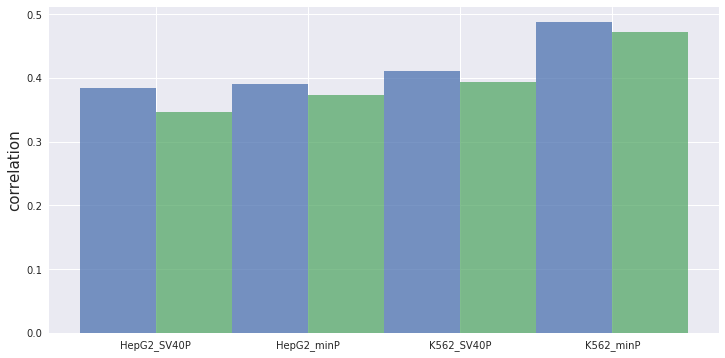

In [10]:
objects = sorted(pearsondict_samedesign.keys())
y_pos = np.arange(len(objects))

pearson_vals = [pearsondict_samedesign[key] for key in objects]
spearman_vals = [spearmandict_samedesign[key] for key in objects]

width = -0.5
plt.figure(figsize = (12, 6))
plt.bar(y_pos, pearson_vals, alpha = 0.75, width = width, align = 'edge')
plt.bar(y_pos + 0.5, spearman_vals, alpha = 0.75, width = width, align = 'edge')
plt.xticks(y_pos, objects, size = 10)
plt.ylabel('correlation', size = 15)
plt.legend(loc = 'upper left', prop={'size': 15})
plt.show()